In [52]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.modeling.functional_models import Gaussian2D

from tqdm import tqdm
from PIL import Image

In [27]:
ang_res = 1
x = np.random.uniform(0,1,5000)*ang_res
y = np.random.uniform(0,1,5000)*ang_res

#means of normal distribution
mu1 = [0.6*ang_res, 0.5*ang_res]
mu2 = [0.3*ang_res, 0.8*ang_res] 
mu3 = [0.9*ang_res, 0.7*ang_res]

#covariance values:
c1 = [[0.0008*ang_res,0],[0,0.0002*ang_res]]
c2 = [[0.0008*ang_res,0],[0,0.0002*ang_res]]
c3 = [[0.0008*ang_res,0],[0,0.0002*ang_res]]

#getting the distribution for peak reagions
d1 = np.random.multivariate_normal(mu1, c1, (3000,3000))
d2 = np.random.multivariate_normal(mu2, c2, (3000,3000))
d3 = np.random.multivariate_normal(mu3, c3, (3000,3000))

d = [d1,d2,d3]

#appending to x and y corrdinates
X = x.copy()
Y = y.copy()
for dist in d:
    dr1 = dist[:,:,0]
    dr2 = dist[:,:,1]
    X = np.concatenate((X,dr1[0]))
    Y = np.concatenate((Y,dr2[1]))

del d,d1,d2,d3

In [28]:
#getting the density map
des_map = np.histogram2d(X,Y,bins=64)

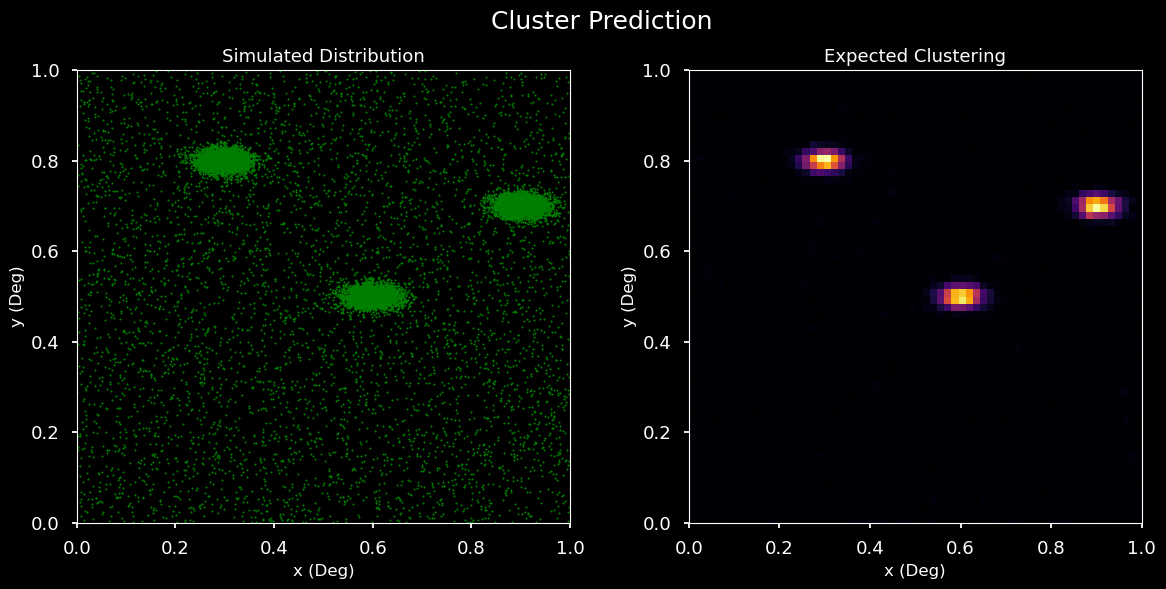

In [29]:
plt.rcParams["font.family"] = 'sans-serif'
plt.style.use('seaborn-talk')

fig, ax = plt.subplots(1,2,figsize=(14,6), dpi=100, gridspec_kw={'wspace':0.2})
ax[0].scatter(X,Y,s=1,c='green')
ax[0].set_xlim(0,ang_res)
ax[0].set_ylim(0,ang_res)

ax[1].imshow(des_map[0].T, origin='lower',cmap='inferno', extent=[0,ang_res,0,ang_res])

ax[0].set_title('Simulated Distribution',fontsize=13)
ax[1].set_title('Expected Clustering'   ,fontsize=13)

for i in range(2):
    ax[i].set_xlabel('x (Deg)',fontsize=12);
    ax[i].set_ylabel('y (Deg)',fontsize=12);
    ax[i].grid(False)
fig.suptitle('Cluster Prediction', fontsize=18);

#plt.savefig('simulated.jpg', bbox_inches='tight', dpi=200)

## In the next few block we will genrete real astrophysical mock data

In [30]:
# generating the data
bkg_data = np.zeros((10000,10000))

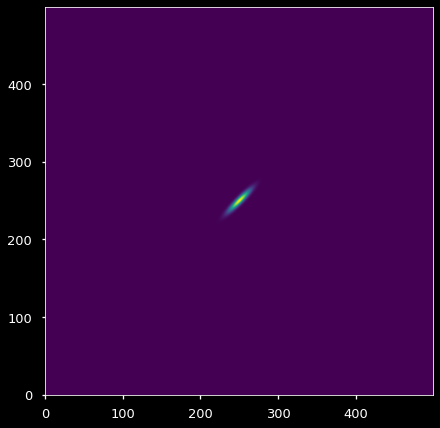

In [31]:
x1 = np.linspace(-1,1,500)
y1 = np.linspace(-1,1,500)

X,Y = np.meshgrid(x1,y1)

a=Gaussian2D.evaluate(X,Y,amplitude=1, x_mean=0, y_mean=0, x_stddev=0.05, y_stddev=0.01, theta=np.pi/4)

plt.imshow(a, origin='lower')


In [32]:
# function to generate mock stars and galaxies

def MockData(bkg, nos, star_no, gal_no, star_size, gal_size):
    # bkg = background data
    # nos = number of sample
    # star_no = number of stars
    # gal_no = number of galaxies 
    # gal_size = size of each galaxy (must me array of type [x_spred,y_spred])
    # star_size = size of each star (must me array of type [x_spred,y_spred])

    
    # checking input parameters
    if nos != star_no + gal_no:
        print('Number of sample must be equal to number of stars + number of galaxies!!')
        return bkg
    else:
        # genreating random x and y mean position for mock data
        block_size = 1000
        pad = (block_size/2)*(ang_res/10000)
        x_mean = np.random.uniform(pad,1-pad,nos)
        y_mean = np.random.uniform(pad,1-pad,nos)

        ## generating star spread array
        x_star_spread = np.random.uniform(0,star_size[0],star_no)
        y_star_spread = np.random.uniform(0,star_size[1],star_no)
        star_rot = np.random.uniform(0,2*np.pi,star_no)


        ## generating galaxy spread array
        x_gal_spread = np.random.uniform(0,gal_size[0],gal_no)
        y_gal_spread = np.random.uniform(0,gal_size[1],gal_no)
        gal_rot = np.random.uniform(0,2*np.pi,gal_no)

        xs = np.linspace(-1,1,500)
        ys = np.linspace(-1,1,500)
        xg = np.linspace(-1,1,1000)
        yg = np.linspace(-1,1,1000)
        
        Xs,Ys = np.meshgrid(xs,ys)
        Xg,Yg = np.meshgrid(xg,yg)

        # generating mock star data
        for i in tqdm(range(star_no), desc='Generating Mock Stars'):
            mock_data = Gaussian2D.evaluate(Xs,Ys,amplitude=1, x_mean=0, y_mean=0, x_stddev=x_star_spread[i], y_stddev=y_star_spread[i], theta=star_rot[i]) 
            bkg[int(x_mean[i]*10000)-250:int(x_mean[i]*10000)+250,int(y_mean[i]*10000)-250:int(y_mean[i]*10000)+250] = mock_data

        # generating mock galaxy data
        for i in tqdm(range(gal_no), desc='Generating Mock Galaxies'):
            mock_data = Gaussian2D.evaluate(Xg,Yg,amplitude=1, x_mean=0, y_mean=0, x_stddev=x_gal_spread[i], y_stddev=y_gal_spread[i], theta=gal_rot[i]) 
            bkg[int(x_mean[i+star_no]*10000)-500:int(x_mean[i+star_no]*10000)+500,int(y_mean[i+star_no]*10000)-500:int(y_mean[i+star_no]*10000)+500] = mock_data

        return bkg
        

In [110]:
def SingleBinPlot(data, bins):
    # intializing the density map
    des_map = np.zeros((bins, bins))
    
    # getting breakpoints
    m,n,r = data.shape
    x = np.linspace(0,m,bins+1)
    y = np.linspace(0,n,bins+1)

    # getting the binned data
    for i in range(bins):
        for j in range(bins):
            des_map[i,j] = np.sum(data[int(x[i]):int(x[i+1]),int(y[j]):int(y[j+1])])

    plt.rcParams["font.family"] = 'sans-serif'
    plt.style.use('seaborn-talk')

    fig, ax = plt.subplots(1,2,figsize=(14,6), dpi=100, gridspec_kw={'wspace':0.2})
    ax[0].imshow(data, origin='lower', extent=[0,ang_res,0,ang_res])
    #ax[0].vlines(x,linestyle='--',color='red')

    ax[1].imshow(des_map,origin='lower',cmap='cubehelix'
                 , extent=[0,ang_res,0,ang_res])
    

    ax[0].set_title('Data',fontsize=13)
    ax[1].set_title('Expected Clustering',fontsize=13)

    for i in range(2):
        ax[i].set_xlabel('x (Deg)',fontsize=12);
        ax[i].set_ylabel('y (Deg)',fontsize=12);
        ax[i].grid(False)
    fig.suptitle('Cluster Prediction', fontsize=18);


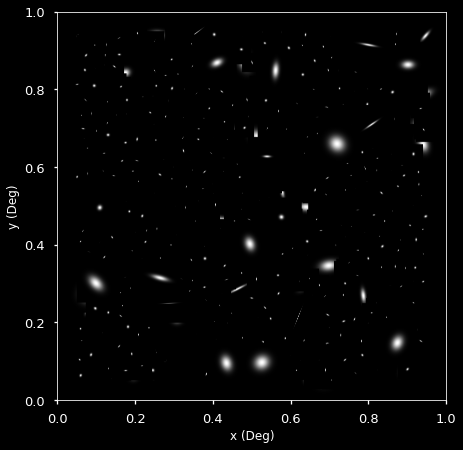

In [103]:
#generated_sample = MockData(bkg_data,nos=500,star_no=480,gal_no=20,star_size=[0.1,0.1],gal_size=[0.3,0.3]) 
#plt.figure(figsize=(10,10), dpi=100)
plt.imshow(generated_sample, origin='lower',cmap='gray', extent=[0,ang_res,0,ang_res])

plt.xlabel('x (Deg)',fontsize=12);
plt.ylabel('y (Deg)',fontsize=12);
#plt.savefig('simulated1.jpg', bbox_inches='tight', dpi=200)#

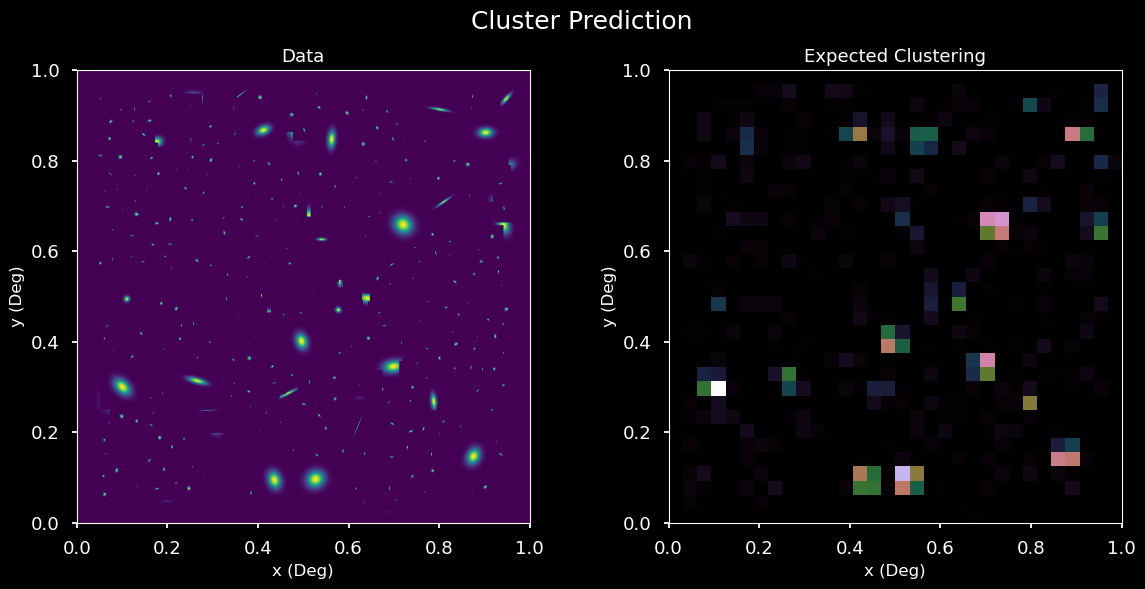

In [104]:
SingleBinPlot(generated_sample,bins=32)

# The next few blocks ran a simple implementaion of the above algorithm.   

In [105]:
from astropy.io import fits

hdu1 = fits.open("DataSet1/DES0142-2041_r4920p02_i.fits.fz")
hdu2 = fits.open("DataSet1/DES0142-2041_r4920p02_r.fits.fz")
hdu3 = fits.open("DataSet1/DES0142-2041_r4920p02_g.fits.fz")

In [106]:
#imageing data
r = hdu1[1].data
g = hdu2[1].data
b = hdu3[1].data

In [107]:
from ginga.util import zscale

def r_b_to_rgb(r_data, g_data, b_data):
    """Zscales data from input data,
     and returns rgb cube for data visualization"""
    
    tmps = [r_data, g_data, b_data]
    datas = []
    for data in tmps:
        z1, z2 = zscale.zscale(data) # computes zscale limits
        data = np.clip(data,z1,z2) # Clips data above/below limits
        lo = np.nanmin(data)
        hi = np.nanmax(data)
        data = ((data-lo)/(hi-lo)) # sets data to [0,1] range
        datas.append(data)

    r_data,g_data, b_data = datas

    # stacks individual array into RGB cube
    stack = np.stack([r_data, g_data, b_data], axis=-1) 
    
    return stack

stack = r_b_to_rgb(r,g,b)

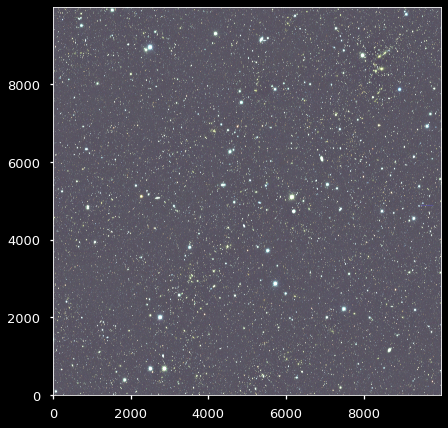

In [115]:
s1 = stack - np.mean(stack)
plt.imshow(stack,origin='lower')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.6244018

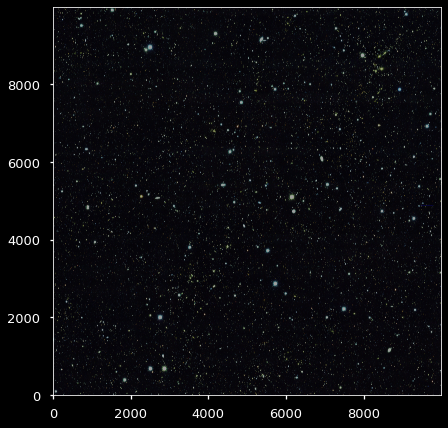

In [117]:
plt.imshow(s1,origin='lower')
np.max(s1)

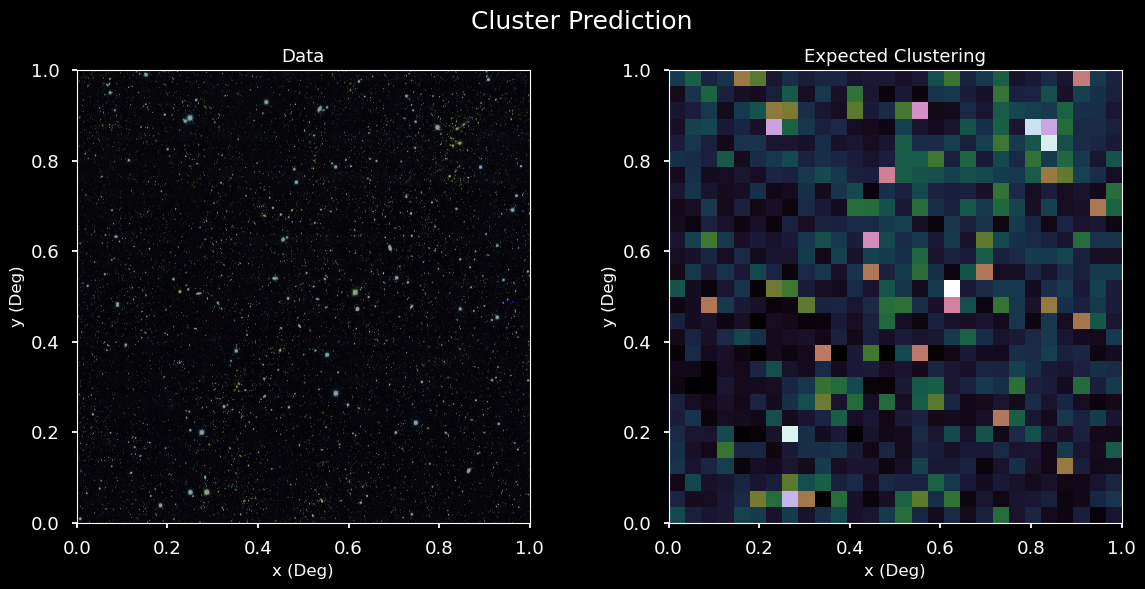

In [120]:

SingleBinPlot(np.clip(s1,0,0.6), 28)
plt.savefig('DES1.jpg', bbox_inches='tight', dpi=200)